In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../..')

# Creature

In [2]:
from lamarck import Creature

In [3]:
genome = {
    'x': 10,
    'y': 'A',
    'z': (1, 2, 3)
}

In [4]:
creature = Creature(genome)

In [5]:
creature.id

-4923803524549828126

# Genome Creator

In [6]:
from lamarck.assistant import GenomeCreator

In [7]:
genome_creator = GenomeCreator()

In [8]:
genome_creator.add_gene_specs.numeric(name='x',
                                      min=0,
                                      max=10,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.categorical(name='y', domain=['A', 'B', 'C', 'D', 'E'])

genome_creator.add_gene_specs.vectorial(name='z', length=4, replace=False, domain=['i', 'j', 'k', 'l', 'm'])

In [9]:
genome_blueprint = genome_creator.get_genome_blueprint()

In [10]:
genome_blueprint

{'x': {'type': 'numeric',
  'domain': 'int',
  'ranges': {'min': 0, 'max': 10, 'progression': 'linear'}},
 'y': {'type': 'categorical', 'domain': ['A', 'B', 'C', 'D', 'E']},
 'z': {'type': 'vectorial',
  'domain': ['i', 'j', 'k', 'l', 'm'],
  'ranges': {'length': 4, 'replace': False}}}

# Population Creator

In [11]:
from lamarck.assistant import PopulationCreator

In [12]:
pop_creator = PopulationCreator(genome_blueprint)

In [13]:
popdet = pop_creator.create.det(8)
popdet

Population with 512 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [14]:
popdet.datasets.input.head()

,x,y,z
id,,,
5652851838151063224,0,A,"(i, j, k, l)"
-795557098888842668,0,A,"(i, l, k, m)"
332427032069065589,0,A,"(j, k, i, l)"
458982184089317286,0,A,"(j, m, k, l)"
414599337400958178,0,A,"(k, l, i, j)"


In [15]:
poprand = pop_creator.create.rand(500)
poprand

Population with 500 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [16]:
poprand.datasets.input.head()

,x,y,z
id,,,
-7355598769063428848,4,E,"(m, k, j, i)"
-5724919469538494420,4,A,"(k, j, i, m)"
-7857553570268349064,2,E,"(k, m, j, l)"
6078628270444982159,2,E,"(i, l, j, k)"
-204012818183505536,4,B,"(i, j, m, l)"


In [17]:
pop = popdet + poprand
pop

Population with 1012 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [18]:
pop.drop_duplicates()
pop

Population with 779 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [19]:
pop.datasets.input.head()

,x,y,z
id,,,
5652851838151063224,0,A,"(i, j, k, l)"
-795557098888842668,0,A,"(i, l, k, m)"
332427032069065589,0,A,"(j, k, i, l)"
458982184089317286,0,A,"(j, m, k, l)"
414599337400958178,0,A,"(k, l, i, j)"


In [20]:
pop.define()

# Environment

In [21]:
from lamarck import Environment

In [22]:
import hashlib

def tuplehash(tuple_obj):
    encoded = ''.join(tuple_obj).encode()
    m = hashlib.md5()
    m.update(encoded)
    d = m.digest()
    return int.from_bytes(d, 'big')
    
    
def dummy_process(x, y, z):
    zval = (tuplehash(z) % 1000) / (x+1)**0.75
    yval = zval // ord(y) + tuplehash((y, y)) % 73
    return {
        'time': (x + 1) * abs(zval - yval) // 10,
        'profit': (abs(3*zval - 2*yval)**((int(x/10) + 1) % 9) // (tuplehash((y, y)) % 7 + 1)) % 10000 + (zval*yval) //10
    }

In [23]:
env = Environment()

In [24]:
env.config.set_process(dummy_process)

In [25]:
env.config.set_output_varibles('time', 'profit')

In [26]:
env.config

multi:   False
output_varibles:   ('time', 'profit')
process:   <function dummy_process at 0x7f7373ad5940>

In [27]:
cr = pop[10]
cr

Creature <6042297926356437636> - genome: {'x': 0, 'y': 'B', 'z': ('j', 'k', 'i', 'l')}

### Simulate Creature

In [28]:
env.simulate(cr)

{'time': 54.0, 'profit': 3384.0}

### Simulate Population

In [29]:
simpop = pop.copy()

In [30]:
env.simulate(simpop)

In [31]:
simpop.datasets.output.head()

,x,y,z,time,profit
id,,,,,
5652851838151063224,0,A,"(i, j, k, l)",95.0,2154.0
-795557098888842668,0,A,"(i, l, k, m)",62.0,1105.0
332427032069065589,0,A,"(j, k, i, l)",56.0,930.0
458982184089317286,0,A,"(j, m, k, l)",27.0,338.0
414599337400958178,0,A,"(k, l, i, j)",45.0,715.0


### Simulate Population - Multi Thread

In [32]:
env.config.set_multi(True)

In [33]:
env.simulate(simpop)

In [34]:
simpop.datasets.output.head()

,x,y,z,time,profit
id,,,,,
5652851838151063224,0,A,"(i, j, k, l)",95.0,2154.0
-795557098888842668,0,A,"(i, l, k, m)",62.0,1105.0
332427032069065589,0,A,"(j, k, i, l)",56.0,930.0
458982184089317286,0,A,"(j, m, k, l)",27.0,338.0
414599337400958178,0,A,"(k, l, i, j)",45.0,715.0


# Fitness

### 1. Single Objective

In [35]:
single_objective_pop = simpop.copy()
single_objective_pop.apply_fitness.single_objective(output='time', objective='min')

In [36]:
single_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria
id,,,,,,
7800982636879079842,1,C,"(l, k, m, j)",0.0,27.0,0.0
-8079716962524445637,7,D,"(k, m, l, j)",0.0,30.0,0.0
-6785697022506774461,0,E,"(l, j, m, k)",0.0,193.0,0.0
4116382070232022655,1,A,"(m, l, i, j)",0.0,3.0,0.0
6873272289056784857,0,B,"(j, l, i, m)",0.0,33.0,0.0


### 2. Multi Objective - Ranked

In [37]:
ranked_objective_pop = simpop.copy()
ranked_objective_pop.apply_fitness.multi_objective.ranked(priorities=['time', 'profit'], objectives=['min', 'max'])

In [38]:
ranked_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1
id,,,,,,,
5485827359507046667,2,E,"(m, i, j, k)",0.0,227.0,0.0,227.0
-6785697022506774461,0,E,"(l, j, m, k)",0.0,193.0,0.0,193.0
6873272289056784857,0,B,"(j, l, i, m)",0.0,33.0,0.0,33.0
-8079716962524445637,7,D,"(k, m, l, j)",0.0,30.0,0.0,30.0
7800982636879079842,1,C,"(l, k, m, j)",0.0,27.0,0.0,27.0


### 3. Multi Objective - Pareto

In [39]:
pareto_objective_pop = simpop.copy()
pareto_objective_pop.apply_fitness.multi_objective.pareto(outputs=['time', 'profit'], objectives=['min', 'max'])

In [40]:
pareto_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1,front,crowd
id,,,,,,,,,
-746557814756240222,10,E,"(i, l, k, m)",64.0,10444.0,-0.034135,6.743807,1,inf
4116382070232022655,1,A,"(m, l, i, j)",0.0,3.0,-1.478809,-0.670945,1,inf
7800982636879079842,1,C,"(l, k, m, j)",0.0,27.0,-1.478809,-0.653901,1,inf
8524391934304797810,10,B,"(l, m, i, j)",13.0,3417.0,-1.185359,1.753532,1,4.529435
-4180426011571564043,10,B,"(l, i, k, m)",22.0,7089.0,-0.982202,4.361230,1,4.223460


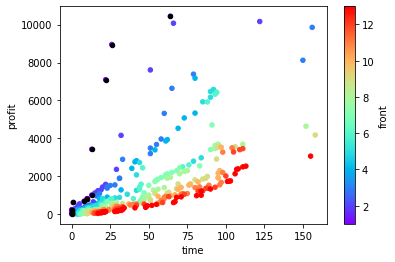

In [41]:
ax = pareto_objective_pop.plot.fronts('time', 'profit', 1)

# Selection

In [42]:
selected_pop = pareto_objective_pop.select()
selected_pop

Population with 389 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [43]:
selected_pop.datasets.fitness

,x,y,z,time,profit,criteria0,criteria1,front,crowd
id,,,,,,,,,
-746557814756240222,10,E,"(i, l, k, m)",64.0,10444.0,-0.034135,6.743807,1,inf
4116382070232022655,1,A,"(m, l, i, j)",0.0,3.0,-1.478809,-0.670945,1,inf
7800982636879079842,1,C,"(l, k, m, j)",0.0,27.0,-1.478809,-0.653901,1,inf
8524391934304797810,10,B,"(l, m, i, j)",13.0,3417.0,-1.185359,1.753532,1,4.529435
-4180426011571564043,10,B,"(l, i, k, m)",22.0,7089.0,-0.982202,4.361230,1,4.223460
...,...,...,...,...,...,...,...,...,...
7992157028042034091,2,C,"(k, l, i, m)",34.0,315.0,-0.711326,-0.449375,13,0.248759
-3480253511376511467,8,E,"(i, l, k, m)",67.0,647.0,0.033584,-0.213603,13,0.243280
-3703033687610536825,2,E,"(j, l, m, i)",107.0,2357.0,0.936505,1.000766,13,0.228367


# Repopulate

In [44]:
newpop = selected_pop.copy()
newpop

Population with 389 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [45]:
newpop.datasets.fitness

,x,y,z,time,profit,criteria0,criteria1,front,crowd
id,,,,,,,,,
-746557814756240222,10,E,"(i, l, k, m)",64.0,10444.0,-0.034135,6.743807,1,inf
4116382070232022655,1,A,"(m, l, i, j)",0.0,3.0,-1.478809,-0.670945,1,inf
7800982636879079842,1,C,"(l, k, m, j)",0.0,27.0,-1.478809,-0.653901,1,inf
8524391934304797810,10,B,"(l, m, i, j)",13.0,3417.0,-1.185359,1.753532,1,4.529435
-4180426011571564043,10,B,"(l, i, k, m)",22.0,7089.0,-0.982202,4.361230,1,4.223460
...,...,...,...,...,...,...,...,...,...
7992157028042034091,2,C,"(k, l, i, m)",34.0,315.0,-0.711326,-0.449375,13,0.248759
-3480253511376511467,8,E,"(i, l, k, m)",67.0,647.0,0.033584,-0.213603,13,0.243280
-3703033687610536825,2,E,"(j, l, m, i)",107.0,2357.0,0.936505,1.000766,13,0.228367


In [46]:
newpop.reproduce.tournament(n_children=len(newpop)/2)

In [47]:
newpop.reproduce.elitism()

Exception ignored in: <generator object generate_elite_parent_pair at 0x7f736ed2c0b0>
Traceback (most recent call last):
  File "<ipython-input-47-f056f8818bf1>", line 1, in <module>
RuntimeError: generator ignored GeneratorExit


In [48]:
newpop

Population with 779 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [49]:
env.simulate(newpop)

In [50]:
newpop.apply_fitness.multi_objective.pareto(outputs=['time', 'profit'], objectives=['min', 'max'])

In [51]:
newpop.datasets.fitness

,x,y,z,time,profit,criteria0,criteria1,front,crowd
id,,,,,,,,,
-746557814756240222,10,E,"(i, l, k, m)",64.0,10444.0,0.909821,6.179240,1,inf
-5953504863434719391,0,A,"(m, l, i, j)",0.0,7.0,-0.992227,-0.619099,1,inf
-7168168632727940521,3,A,"(m, l, i, j)",0.0,1.0,-0.992227,-0.623007,1,inf
8637493895296498366,10,B,"(m, l, k, i)",16.0,4537.0,-0.516715,2.331603,1,2.659303
-5654149293634853650,10,B,"(j, m, k, l)",26.0,8951.0,-0.219520,5.206746,1,2.433139
...,...,...,...,...,...,...,...,...,...
666611784559119680,8,C,"(j, m, k, l)",33.0,117.0,-0.011483,-0.547449,9,0.000000
692190509242214479,9,C,"(l, k, j, i)",9.0,52.0,-0.724752,-0.589787,9,0.000000
-232705137974902833,2,A,"(l, m, i, j)",25.0,81.0,-0.249239,-0.570898,9,0.000000


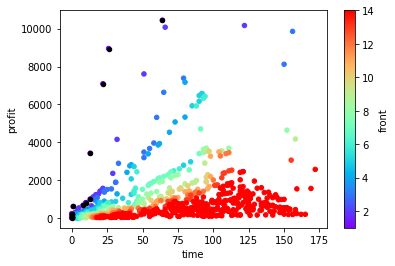

In [52]:
ax = pareto_objective_pop.plot.fronts('time', 'profit', 1, show_worst=True)

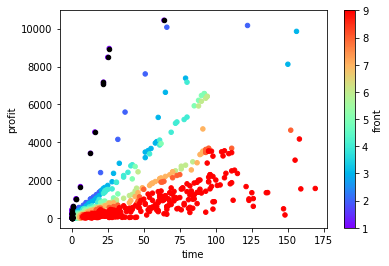

In [53]:
ax = newpop.plot.fronts('time', 'profit', 1, show_worst=True)

In [54]:
newpop.save_to_history()

## Mutation